In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
%matplotlib inline

S Tse 4/14/18

This notebook attempts to duplicate the centroid allocation method to convert demographic metrics from a smaller geography (in this case, census block groups) to a larger goegraphy (in this case, PDX neighborhoods). This methodology is baked into many commercial GIS packages such as ESRI and Alteryx. You can find some descriptions here:

    https://help.alteryx.com/9.5/Allocate_Retrieval_Methodology.htm
    https://doc.arcgis.com/en/esri-demographics/reference/data-allocation-method.htm
    
In this notebook I took this basic approach:

* calculate centroids of the smaller census block group geography
* using geopandas, do a spatial join to determine which census block centroid point lay within which neighborhood boundaries
* allocate the block group population its corresponding neighhorhood as defined by the spatial join above
* sum the population as grouped by neighborhood
    

In [2]:
# read in block group data
acs_pop = pd.read_csv("ACS_16_5YR_B01003/ACS_16_5YR_B01003_with_ann.csv", skiprows=1)

In [3]:
acs_pop.head()

,Id,Id2,Geography,Estimate; Total,Margin of Error; Total
0,1500000US410050201001,410050201001,"Block Group 1, Census Tract 201, Clackamas Cou...",2025,294
1,1500000US410050201002,410050201002,"Block Group 2, Census Tract 201, Clackamas Cou...",923,186
2,1500000US410050201003,410050201003,"Block Group 3, Census Tract 201, Clackamas Cou...",924,188
3,1500000US410050202001,410050202001,"Block Group 1, Census Tract 202, Clackamas Cou...",1291,349
4,1500000US410050202002,410050202002,"Block Group 2, Census Tract 202, Clackamas Cou...",1417,362


In [4]:
acs_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 5 columns):
Id                        1041 non-null object
Id2                       1041 non-null int64
Geography                 1041 non-null object
Estimate; Total           1041 non-null int64
Margin of Error; Total    1041 non-null int64
dtypes: int64(3), object(2)
memory usage: 40.7+ KB


In [5]:
or_bg = gpd.read_file("cb_2016_41_bg_500k\cb_2016_41_bg_500k.shp")

In [6]:
or_bg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 11 columns):
STATEFP     2628 non-null object
COUNTYFP    2628 non-null object
TRACTCE     2628 non-null object
BLKGRPCE    2628 non-null object
AFFGEOID    2628 non-null object
GEOID       2628 non-null object
NAME        2628 non-null object
LSAD        2628 non-null object
ALAND       2628 non-null int64
AWATER      2628 non-null int64
geometry    2628 non-null object
dtypes: int64(2), object(9)
memory usage: 225.9+ KB


In [7]:
or_bg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,41,005,020900,1,1500000US410050209001,410050209001,1,BG,443749,0,"POLYGON ((-122.63656 45.461474, -122.626278 45..."
1,41,047,002102,2,1500000US410470021022,410470021022,2,BG,287579,0,"POLYGON ((-123.05852 44.89242, -123.0575 44.89..."
2,41,029,000601,2,1500000US410290006012,410290006012,2,BG,2039310,0,"POLYGON ((-122.840623 42.32259699999999, -122...."
3,41,053,020202,1,1500000US410530202021,410530202021,1,BG,2461050,0,"POLYGON ((-123.31504 44.925904, -123.313628 44..."
4,41,035,971600,3,1500000US410359716003,410359716003,3,BG,743067,0,"POLYGON ((-121.759991 42.217678, -121.748249 4..."


In [8]:
# check projection of block group polygons
or_bg.crs

{'init': 'epsg:4269'}

In [9]:
# convert the 'Id2' column in the ACS to string
acs_pop['Id2'] = acs_pop['Id2'].astype(str)

In [10]:
# merge ACS data onto CBG shapefiles
or_bg_merged = or_bg.merge(acs_pop, left_on='GEOID', right_on='Id2', how = 'inner')

In [11]:
or_bg_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1041 entries, 0 to 1040
Data columns (total 16 columns):
STATEFP                   1041 non-null object
COUNTYFP                  1041 non-null object
TRACTCE                   1041 non-null object
BLKGRPCE                  1041 non-null object
AFFGEOID                  1041 non-null object
GEOID                     1041 non-null object
NAME                      1041 non-null object
LSAD                      1041 non-null object
ALAND                     1041 non-null int64
AWATER                    1041 non-null int64
geometry                  1041 non-null object
Id                        1041 non-null object
Id2                       1041 non-null object
Geography                 1041 non-null object
Estimate; Total           1041 non-null int64
Margin of Error; Total    1041 non-null int64
dtypes: int64(4), object(12)
memory usage: 138.3+ KB


In [12]:
or_bg_merged['centroids'] = or_bg_merged['geometry'].centroid

In [13]:
or_bg_merged['centroids'].head()

0     POINT (-122.6274832701011 45.4600762175877)
1    POINT (-122.4388107302967 45.51494191760992)
2    POINT (-122.7707272349793 45.41443462008048)
3     POINT (-122.4242741369357 45.4956246343169)
4    POINT (-122.6077321184235 45.50182185147766)
Name: centroids, dtype: object

#### Now that centroids have been generated, let's access the larger geometry. In this case, they are PDX neighborhoods*.

*Neighborhood shapefiles downloaded from [PDX Maps](http://gis-pdx.opendata.arcgis.com/datasets/cd78700c5c5c4a338090ce4c7b996f03_3?geometry=-123.593%2C45.374%2C-121.741%2C45.711).


In [14]:
neighborhoods = gpd.read_file("pdx_neighborhoods/Neighborhood_Boundaries.shp")

In [15]:
neighborhoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 9 columns):
OBJECTID      130 non-null int64
NAME          130 non-null object
COMMPLAN      57 non-null object
SHARED        27 non-null object
COALIT        130 non-null object
HORZ_VERT     125 non-null object
Shape_Leng    130 non-null float64
MAPLABEL      130 non-null object
geometry      130 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 9.2+ KB


In [16]:
# verify coordinate system of polygons in  neighborhoods geodataframe
neighborhoods.crs

{'init': 'epsg:4326'}

In [17]:
neighborhoods.head()

,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Leng,MAPLABEL,geometry
0,1,ST. JOHNS,None,None,NPNS,HORZ,32669.063081,St. Johns,POLYGON ((-122.7923191957859 45.61978371722063...
1,2,HAYDEN ISLAND NEIGHBORHOOD NETWORK,None,None,NPNS,HORZ,27707.083425,Hayden Island Neighborhood Network,POLYGON ((-122.7475117396571 45.64005156754342...
2,3,LINNTON,None,None,NWNW,HORZ,52741.719772,Linnton,POLYGON ((-122.8237089611819 45.60615857772244...
3,4,FOREST PARK/LINNTON,None,Y,NWNW,HORZ,57723.635350,Forest Park/Linnton,POLYGON ((-122.8231909270121 45.60615651892255...
4,5,KENTON,ALBINA,None,NPNS,VERT,19182.565606,Kenton,POLYGON ((-122.6816166816783 45.60713031403424...


In [18]:
# neighborhoods are in 4326 which is Hack OR informal "standard". I'll reproject the CBG to 4326
or_bg_merged = or_bg_merged.to_crs({'init': 'epsg:4326'})

In [19]:
or_bg_merged.crs

{'init': 'epsg:4326'}

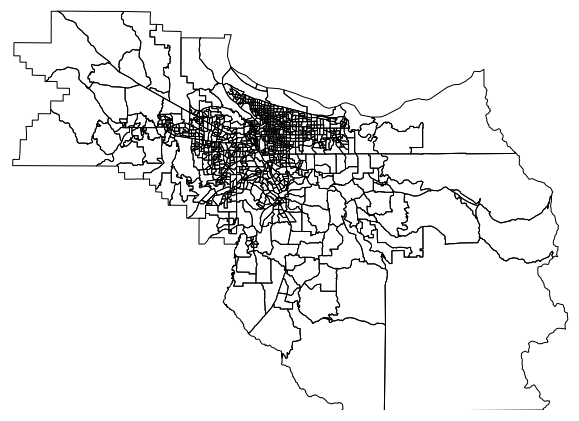

In [20]:
# before going further, let's map both geodataframes
proj = gcrs.AlbersEqualArea()
ax = gplt.polyplot(or_bg_merged, projection=proj,figsize=(10, 10))

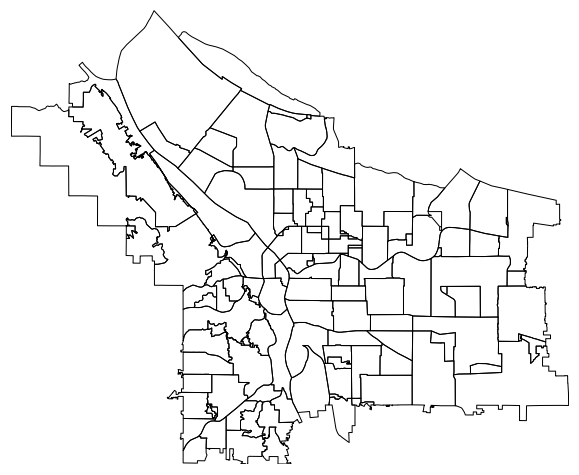

In [21]:
ax = gplt.polyplot(neighborhoods, projection=proj,figsize=(10, 10))

## which neighborhood is the centroid of each block group in?

In [22]:
from geopandas import GeoDataFrame
#GeoDataFrame(df, crs=crs, geometry=geometry)

bg_points = GeoDataFrame(or_bg_merged[['TRACTCE','GEOID','centroids','Estimate; Total']],
                         crs= {'init': 'epsg:4326'},
                         geometry='centroids')

In [23]:
# spatial join if block groupds are within neighborhoods

joined = gpd.sjoin(bg_points, neighborhoods, op='within')

In [24]:
joined = joined[['TRACTCE','GEOID','centroids', 'NAME', 'Estimate; Total']]
joined.head(25)

,TRACTCE,GEOID,centroids,NAME,Estimate; Total
0,020900,410050209001,POINT (-122.6274832701011 45.4600762175877),ARDENWALD-JOHNSON CREEK,1164
71,020900,410050209002,POINT (-122.6280497631264 45.45620207080746),ARDENWALD-JOHNSON CREEK,1304
440,020900,410050209003,POINT (-122.6275117099278 45.45083462448034),ARDENWALD-JOHNSON CREEK,1490
4,000801,410510008012,POINT (-122.6077321184235 45.50182185147766),SOUTH TABOR,1249
98,000701,410510007012,POINT (-122.58346857913 45.49950810852124),SOUTH TABOR,1125
232,000701,410510007014,POINT (-122.595531632871 45.50341001990869),SOUTH TABOR,792
374,000701,410510007013,POINT (-122.5937675550467 45.4993695939645),SOUTH TABOR,1550
791,000701,410510007011,POINT (-122.585252346842 45.50336808009638),SOUTH TABOR,1288
1013,000801,410510008011,POINT (-122.6022109032306 45.50084200461563),SOUTH TABOR,1165
9,003901,410510039015,POINT (-122.708836609535 45.58803941086406),PORTSMOUTH,2766


In [25]:
# sum population by neighborhood
joined.groupby('NAME')['Estimate; Total'].sum().sort_values(ascending=False)

NAME
CENTENNIAL COMMUNITY ASSOCIATION                                    24616
POWELLHURST-GILBERT                                                 22973
MONTAVILLA                                                          19185
LENTS                                                               18310
HAZELWOOD                                                           18215
NORTHWEST DISTRICT ASSOCIATION                                      16352
MILL PARK                                                           15943
ST. JOHNS                                                           15170
PLEASANT VALLEY                                                     14300
BRENTWOOD-DARLINGTON                                                13482
CULLY ASSOCIATION OF NEIGHBORS                                      13024
RICHMOND                                                            12676
PORTSMOUTH                                                          12340
PORTLAND DOWNTOWN                

In [26]:
# put series data in dataframe for summary and plotting
rollup = pd.DataFrame(joined.groupby('NAME')['Estimate; Total'].sum()).reset_index()

In [27]:
rollup.head(10)

,NAME,Estimate; Total
0,ALAMEDA,3657
1,ALAMEDA/IRVINGTON COMMUNITY ASSN.,1452
2,ARBOR LODGE,5425
3,ARDENWALD-JOHNSON CREEK,3958
4,ARGAY TERRACE,5943
5,ARLINGTON HEIGHTS,1405
6,ARNOLD CREEK,2541
7,ASHCREEK,4050
8,BEAUMONT-WILSHIRE,7367
9,BOISE,3288


In [28]:
# summary stats of the neighborhood population after the centroid allocation conversion
rollup.describe()

,Estimate; Total
count,94.000000
mean,6657.223404
std,4914.386185
min,1156.000000
25%,3490.000000
50%,5804.000000
75%,8425.750000
max,24616.000000


In [29]:
population_df = neighborhoods.merge(rollup, on='NAME', how='inner')

Text(0.5,1,'Population by Neighorhood')

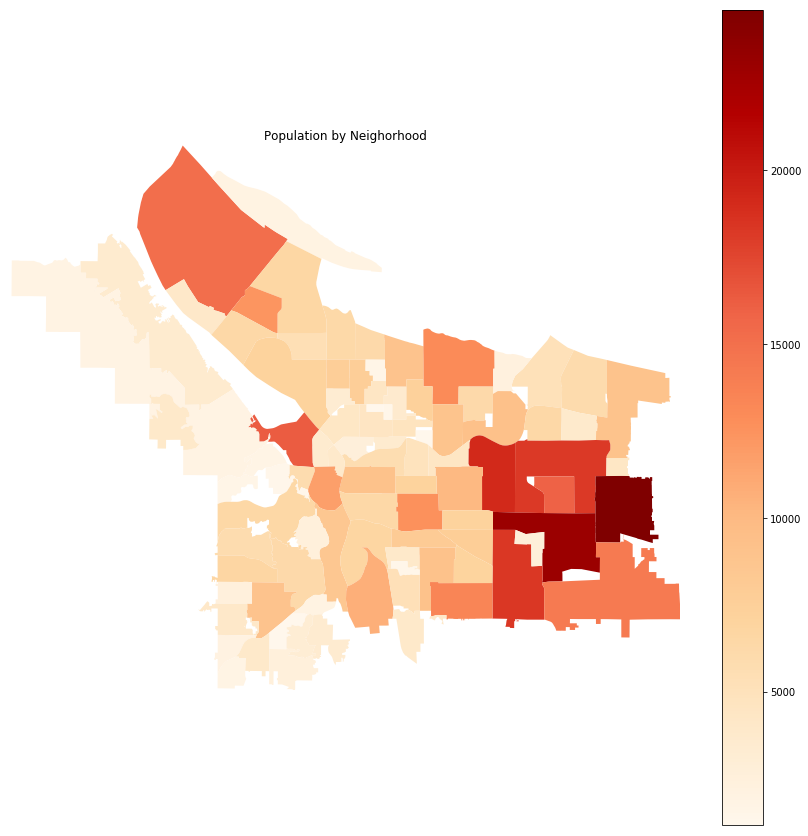

In [30]:
# plot choropleth of population by neighborhood unit

gplt.choropleth(population_df,
                hue=population_df['Estimate; Total'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(15, 15))

plt.title("Population by Neighorhood")